In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm

from src.utils.visualization.visualization_utils import set_size, load_colors, initialize_plot
%load_ext autoreload
%autoreload 2
from pyrootutils import pyrootutils
from hydra import initialize, compose
from os import path
import os
from src.systems.systems.dynamic_system import VanDerPolType
from src.utils.visualization.run_plotter import RunPlotter, MultiRunPlotter
from src.systems.runner.predict_test_runner import PredictTestRunner
from src.systems.enviroment.trajectory_replay_env import TrajectoryReplay
from src.data.dataset.base import BasePckHdf5Loader
from src.modules.nd_cnp import NdCNP
from src.systems.predictor.moving_window_nn_predictor import MovingWindowNNPredictor
from src.systems.systems.NNModel import NNModel
import pickle
from typing import List
from src.systems.runner.predict_test_runner import EnvRunResult
import torch

root = pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
config_path = os.path.relpath(os.path.join(root, "configs"), os.path.abspath(''))
with initialize(version_base=None, config_path=config_path):
    cfg = compose(overrides=[], config_name="notebook")
c = load_colors()
params = initialize_plot('README')  # specifies font size etc., adjust accordingly
plt.rcParams.update(params)

In [2]:
plotter = MultiRunPlotter(VanDerPolType())
res = plotter.load_pkl([
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/normal_nn/runs/2023-07-26_15-21-17/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_20/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win300/runs/2023-07-20_14-33-07/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win300-exactReset/runs/2023-07-20_14-32-58/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-srini0.999/multiruns/2023-12-04_17-28-26/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-srini0.95tA/multiruns/2023-12-04_17-28-22/0/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum95/multiruns/2023-12-05_22-28-55/0/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum95_tA/multiruns/2023-12-05_22-29-02/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum_tight_999/multiruns/2023-12-13_19-48-00/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum_tight95_tA/multiruns/2023-12-13_19-47-59/0/predictor_test__results.pkl.gzip"),
    
    
],
    run_idx=None)



(5.507126055071261, 2.3936455481005825)


/tmp/ipykernel_14180/699541176.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


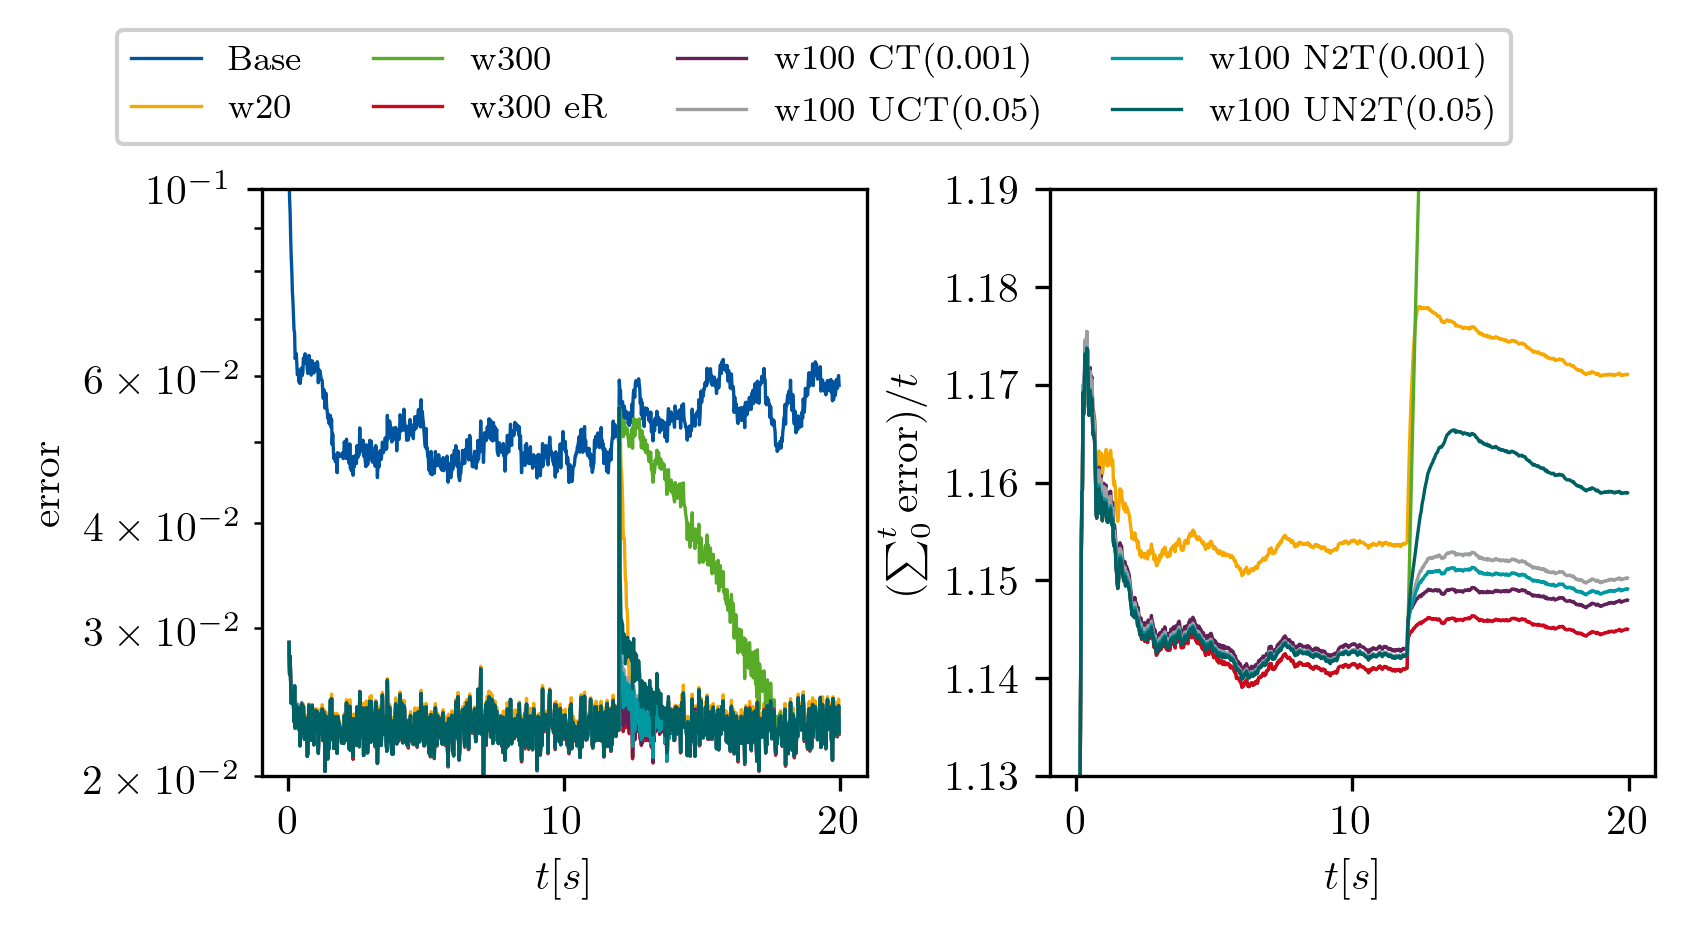

In [3]:
delta_t = 0.02
linewidth= 0.8
size = set_size(width_pt=398, fraction=1.0, subplots=(1, 2))
print(size)
size = (5.5, 2.5)
fig, axs = plt.subplots(1, 2 , figsize=size, dpi=300)
labels = ["Base", "w20","w300", "w300 eR", "w100 CT(0.001)", "w100 UCT(0.05)","w100 N2T(0.001)", "w100 UN2T(0.05)"]
time = torch.arange(2 * delta_t, res[0][0].prediction.error.toSystem.size(0) * delta_t, delta_t)
data = []
error_axs = axs[0]
cum_axs = axs[1]
#cum_axs.set_xlim(10, 15)
cum_axs.set_ylim(1.13, 1.19)
cum_axs.set_ylabel("$(\sum_0^t \\text{error})/t$")
cum_axs.set_xlabel("$t [s]$")
#zoom_axs.set_yticks([])

to_pickle_data = {
    "time": time,
    "mean": [],
    "cum_mean": [],
    "labels": labels
}

i = 0
for run, label in zip(res, labels):
    error = torch.stack([res.prediction.error.toSystem for res in run])
    error = error[:, 2:]  # remove first and second steps because the costs can sometime only be calculated after the first step
    error  = error / torch.tensor(VanDerPolType().inc_std)
    mean = error.mean(dim=(0, 2))

    error_axs.plot(time, mean, label=label, linewidth=linewidth)

    cum_mean = mean.cumsum(dim=0)
    time_normalized_cum_mean = cum_mean / time

    cum_axs.plot(time, time_normalized_cum_mean, linewidth=linewidth)
    
    to_pickle_data["mean"].append(mean)
    to_pickle_data["cum_mean"].append(time_normalized_cum_mean)
    i += 1

error_axs.set_yscale("log")
error_axs.set_ylim(0.02, 0.1)
error_axs.set_xlabel("$t [s]$")
error_axs.set_ylabel("error")
fig.legend(loc='upper left', bbox_to_anchor=(0.05, 1.2),
           ncol=4, fontsize="small",
           #handlelength=0.9,
           #columnspacing=0.6,
           #handletextpad=0.6,
           framealpha=0.95)
fig.tight_layout(pad=0.3)
fig.show()
fig.savefig("/tmp/vdp_pred.pdf", bbox_inches='tight')

with open("/tmp/vdp_pred.pkl", "wb") as f:
    pickle.dump(to_pickle_data, f)

(5.507126055071261, 2.3936455481005825)


/tmp/ipykernel_5271/3342687218.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


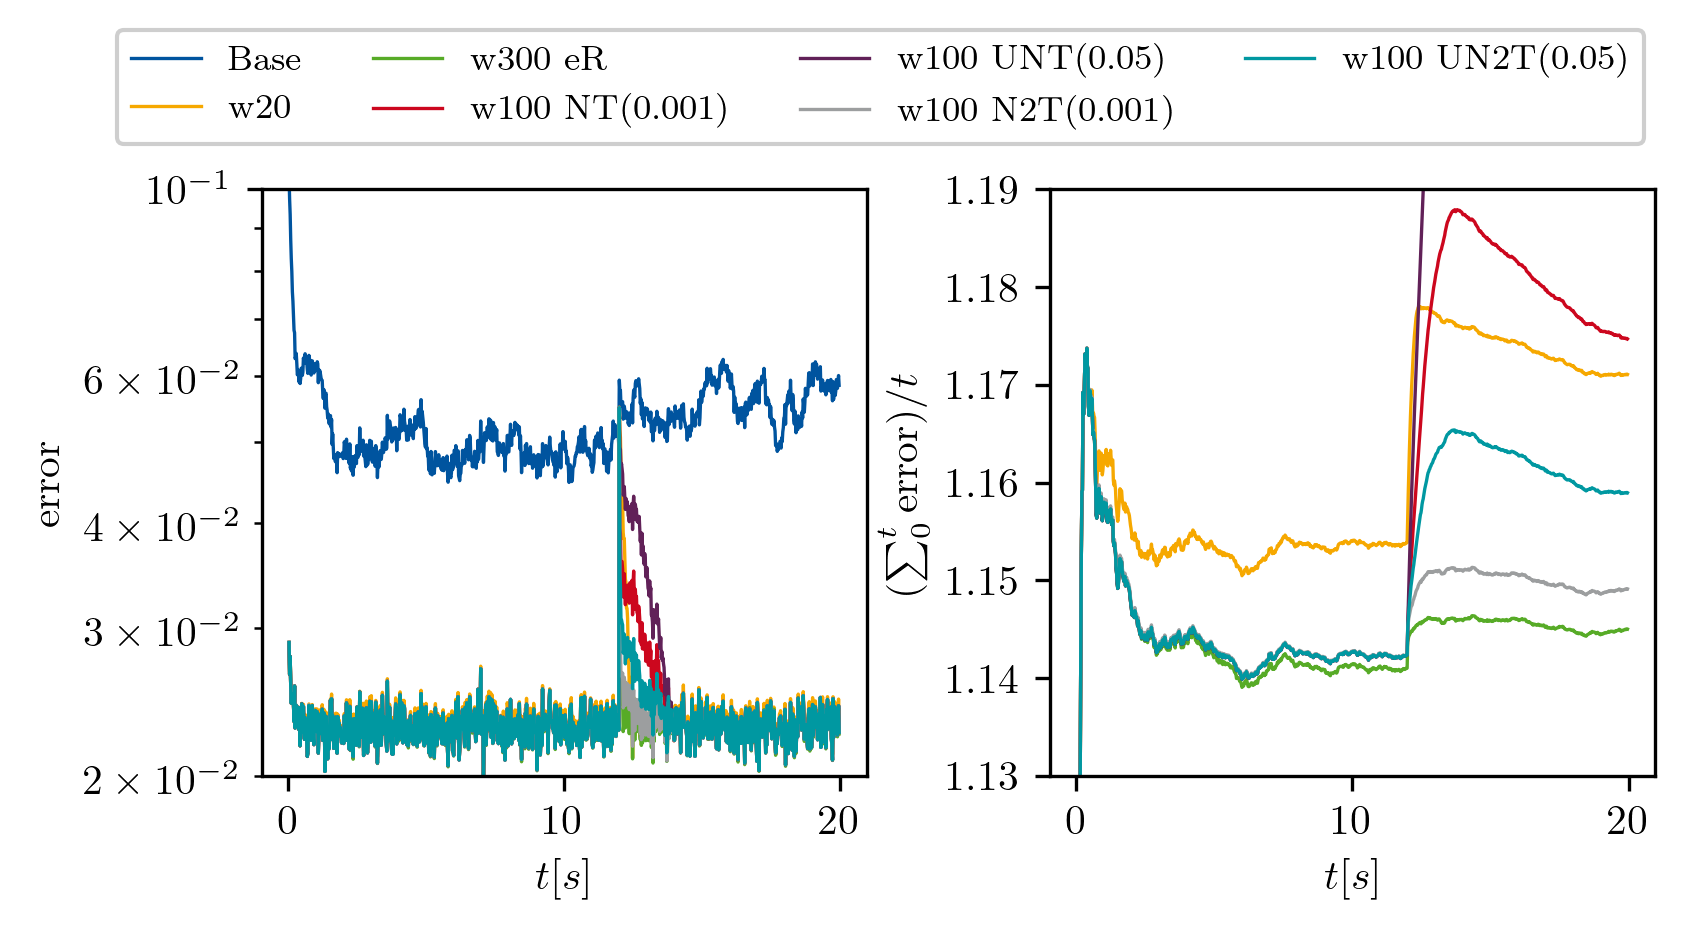

In [19]:
plotter = MultiRunPlotter(VanDerPolType())
res = plotter.load_pkl([
    os.path.join(cfg.paths.log_dir,
                 "vdp_eval/ETL/oneChangeLarge-rC/normal_nn/runs/2023-07-26_15-21-17/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir,
                 "vdp_eval/ETL/oneChangeLarge-rC/pred-test-rC-winSizeSweep/multiruns/2023-07-20_15-03-45/winSize_20/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir,
                 "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win300-exactReset/runs/2023-07-20_14-32-58/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-srini0.999/multiruns/2023-12-04_17-28-26/0/predictor_test__results.pkl.gzip"),
    #os.path.join(cfg.paths.log_dir,"vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-srini0.95tA/multiruns/2023-12-04_17-28-22/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum999/multiruns/2023-12-16_16-53-43/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir, "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum95_tA/multiruns/2023-12-05_22-29-02/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir,
                 "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum_tight_999/multiruns/2023-12-13_19-48-00/0/predictor_test__results.pkl.gzip"),
    os.path.join(cfg.paths.log_dir,
                 "vdp_eval/ETL/oneChangeLarge-rC/pred-test-win100-normal_sum_tight95_tA/multiruns/2023-12-13_19-47-59/0/predictor_test__results.pkl.gzip"),
],
    run_idx=None)

delta_t = 0.02
linewidth= 0.8
size = set_size(width_pt=398, fraction=1.0, subplots=(1, 2))
print(size)
size = (5.5, 2.5)
fig, axs = plt.subplots(1, 2 , figsize=size, dpi=300)
labels = ["Base", "w20", "w300 eR", "w100 NT(0.001)", "w100 UNT(0.05)","w100 N2T(0.001)", "w100 UN2T(0.05)"]
time = torch.arange(2 * delta_t, res[0][0].prediction.error.toSystem.size(0) * delta_t, delta_t)
data = []
error_axs = axs[0]
cum_axs = axs[1]
#cum_axs.set_xlim(10, 15)
cum_axs.set_ylim(1.13, 1.19)
cum_axs.set_ylabel("$(\sum_0^t \\text{error})/t$")
cum_axs.set_xlabel("$t [s]$")
#zoom_axs.set_yticks([])

to_pickle_data = {
    "time": time,
    "mean": [],
    "cum_mean": [],
    "labels": labels
}

i = 0
for run, label in zip(res, labels):
    error = torch.stack([res.prediction.error.toSystem for res in run])
    error = error[:, 2:]  # remove first and second steps because the costs can sometime only be calculated after the first step
    error  = error / torch.tensor(VanDerPolType().inc_std)
    mean = error.mean(dim=(0, 2))

    error_axs.plot(time, mean, label=label, linewidth=linewidth)

    cum_mean = mean.cumsum(dim=0)
    time_normalized_cum_mean = cum_mean / time

    cum_axs.plot(time, time_normalized_cum_mean, linewidth=linewidth)
    
    to_pickle_data["mean"].append(mean)
    to_pickle_data["cum_mean"].append(time_normalized_cum_mean)
    i += 1

error_axs.set_yscale("log")
error_axs.set_ylim(0.02, 0.1)
error_axs.set_xlabel("$t [s]$")
error_axs.set_ylabel("error")
fig.legend(loc='upper left', bbox_to_anchor=(0.05, 1.2),
           ncol=4, fontsize="small",
           #handlelength=0.9,
           #columnspacing=0.6,
           #handletextpad=0.6,
           framealpha=0.95)
fig.tight_layout(pad=0.3)
fig.show()
fig.savefig("/tmp/vdp_pred_norms.pdf", bbox_inches='tight')

with open("/tmp/vdp_pred_norms.pkl", "wb") as f:
    pickle.dump(to_pickle_data, f)